In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
# clean printing
from pprint import pprint

In [49]:
df = pd.read_excel("/content/DocumentsData.xlsx")
df.head()

,Id,Doc Name
0,1,"Nozzle, 220542"
1,2,Value Collection 15 Inch Long x 12 Inch Wide x...
2,3,Made in USA 18 Inch Long x 13 Inch Wide x 4 mi...
3,4,"8""W x 10""L 4mil Clear Reclosable Bag"
4,5,Value Collection 12 Inch Long x 9 Inch Wide x ...


In [50]:
df.rename(columns={'Doc Name':'Doc_Name'},inplace=True)

In [52]:
# Convert to list
data = df.Doc_Name.values.tolist()

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

pprint(data[:1])

['Nozzle, 220542']


## Tokenize and Clean-up using gensim’s simple_preprocess()
##      -  sentence into a list of words, 
##      -  removing punctuations and unnecessary characters altogether.

## Gensim (gensim.utils)--> simple_preprocess() 

In [53]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc=True)) # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['nozzle']]


## Lemmatization
- Lemmatization is a process where we convert words to its root word.

- For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

- The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

- You can expect better topics to be generated in the end.

In [54]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

**Perform lemmitization and pickle that file as it takes some time to process**


In [55]:
data_lemmatized = lemmatization(data_words, 
                                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
import pickle
pickle_out = open("data_lemmatized_save.pickle","wb")
pickle.dump(data_lemmatized, pickle_out)
pickle_out.close()

In [56]:
pickle_in = open("data_lemmatized_save.pickle","rb")
data_lemmatized = pickle.load(pickle_in)
data_lemmatized[2]

'make long inch wide ziplock reclosable bag heavy duty grade'

**Create the Document-Word matrix**

The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. 

- consider words that has occurred at least 10 times (min_df), 
- remove built-in english stopwords, 
- convert all words to lowercase, 
- and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.



In [57]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Check the Sparsicity
- Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

- Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [58]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  7.166153846153846 %


In [59]:
#Build LDA model with sklearn
#Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

#For this example, I have set the n_topics as 10 . Later we will find the optimal number using grid search.

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


## Diagnose model performance with perplexity and log-likelihood
- A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [60]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -8213.027889162917
Perplexity:  32.08342302950883
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


 - On a different note,perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

**How to GridSearch the best LDA model?**

The most important tuning parameter for LDA models 
- n_components (number of topics). 
- learning_decay (which controls the learning rate)



In [61]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [62]:
# model pickle
pickle_out = open("gridsearch_model.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [63]:
# Load model from pickle
pickle_in = open("gridsearch_model.pickle","rb")
model = pickle.load(pickle_in)


In [64]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2463.981860055017
Model Perplexity:  28.21250459372045


**Dominant topic in each document**

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.


In [67]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Doc1,0.16,0.01,0.01,0.25,0.01,0.52,0.01,0.01,0.01,0.01,5
Doc2,0.01,0.01,0.01,0.34,0.01,0.55,0.01,0.01,0.01,0.01,5
Doc3,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Doc4,0.16,0.01,0.01,0.25,0.01,0.52,0.01,0.01,0.01,0.01,5


In [68]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values(by = "Topic Num").reset_index(drop=True)

,Topic Num,Num Documents
0,0,120
1,1,41
2,2,31
3,3,32
4,4,36
5,5,55
6,6,23
7,7,45
8,8,91
9,9,26


**Topic’s keywords**

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.


In [71]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,alloy,aluminum,attach,black,brand,button,cap,carbon,change,class,cloth,coarse,coat,cobalt,collection,color,disc,drill,drive,duty,fine,finish,flat,general,glove,gold,grade,head,heavy,hex,inch,jobber,length,long,low,ltr,machine,max,metal,nylon,oxide,plain,plate,point,purpose,quick,resistant,roll,screw,sheet,size,socket,split,stainless,standard,steel,straight,straw,thread,type,unbrako,value,washer,wide,zinc
Topic0,31.958314,0.100000,0.1,29.100135,0.100000,9.818553,41.923201,0.1,0.1,0.100000,0.100000,8.099998,0.100000,0.1,12.099936,0.100000,0.1,0.100000,0.100016,0.100001,0.100000,35.282116,15.025391,0.100000,0.100000,0.100000,7.550846,8.054930,0.100001,0.100019,0.100001,0.1,5.174780,0.100001,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,29.099937,0.100006,8.334528,0.100000,0.100000,0.1,0.100000,0.100000,47.032931,0.100000,0.100000,33.780779,0.100000,12.099583,2.368404,48.348197,0.100000,0.1,10.607617,0.100001,0.1,12.921196,0.100007,0.100001,0.100006
Topic1,0.100003,0.100003,0.1,0.100000,0.100010,0.100000,0.100000,21.1,0.1,0.100044,0.100000,0.100000,0.100005,0.1,0.100012,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,35.183862,13.174626,13.099984,0.100000,0.100000,0.100017,0.100000,0.100000,0.100000,0.100011,0.1,0.100000,0.100000,20.099973,0.1,0.100000,0.100002,0.100001,0.100000,0.100000,0.100000,1.865444,0.100001,13.099998,0.1,0.100000,0.100002,0.100003,0.100001,0.100009,0.100000,0.100002,0.100007,0.100049,39.379529,0.100000,0.1,0.100002,10.652949,0.1,0.100012,17.099992,0.100000,33.099899
Topic2,25.073705,0.100000,0.1,0.100002,12.100106,1.381447,5.276799,0.1,0.1,0.100000,0.100000,0.100012,0.100000,0.1,0.100004,0.100000,0.1,0.100000,29.099930,0.100000,0.100000,0.100003,0.100000,0.100000,0.100000,0.100000,0.100008,8.466966,0.100000,29.099969,0.100000,0.1,0.100010,0.100000,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,0.100002,31.099994,0.100001,0.100001,0.100000,0.1,0.100000,0.100000,31.839829,0.100000,0.100000,33.419218,0.100000,0.100000,0.100001,24.508462,0.100000,0.1,0.100009,0.100000,12.1,0.100005,0.100000,0.100000,0.100000
Topic3,0.100000,0.100000,0.1,0.100002,0.100000,0.100000,0.100000,0.1,0.1,11.099956,0.100000,4.100014,0.100000,0.1,0.100016,0.100000,0.1,22.099965,0.100000,25.099992,0.100000,27.257457,0.100000,0.100000,0.100000,0.100000,0.100002,0.100000,26.099988,0.100000,14.195973,22.1,5.099930,0.100003,0.100000,0.1,0.100000,0.100000,0.100000,0.100001,22.100077,0.100000,0.100000,23.099918,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100002,0.100000,0.100001,9.100086,4.267055,4.100098,22.1,9.099990,0.100002,0.1,0.100006,0.100000,0.100003,0.100001
Topic4,0.100000,0.100000,0.1,9.278036,0.100124,0.100000,0.100000,0.1,0.1,0.100000,0.100000,0.100000,11.967230,0.1,0.100000,11.099999,0.1,0.100000,0.100000,0.100000,0.100000,0.100007,0.100000,4.100014,13.099996,0.100000,0.100002,0.100000,0.100000,0.100000,0.100002,0.1,0.100000,0.100026,0.100019,0.1,0.100000,0.100000,0.100000,0.100008,0.100000,0.100000,0.100000,0.100001,3.100000,0.1,15.099988,0.100064,0.100000,0.100000,24.099990,0.100000,0.100000,0.100001,0.100039,0.100003,0.100031,0.1,0.100000,0.100018,0.1,0.100000,0.100000,1.113996,0.100000
Topic5,0.100000,15.099997,13.1,5.921815,1.099761,0.100000,0.100000,0.1,15.1,0.100000,3.730282,2.099976,5.232763,0.1,0.100033,0.100001,18.1,0.100000,0.100000,0.100007,16.065224,0.100002,0.100006,0.100002,0.100003,0.100006,25.816172,0.100005,0.100011,0.100000,26.004001,0.1,0.100014,16.099964,0.100007,0.1,0.100000,13.099997,0.100012,13.099959,20.099983,0.100000,0.100008,0.100000,0.100002,15.1,0.100009,4.099998,0.100000,0.100009,0.100001,0.100000,0.100003,0.100000,2.831416,0.100002,6.099855,0.1,0.100000,18.800727,0.1,3.278767,0.100000,17.085993,0.100001
Topic6,2.267978,0.100000,0.1,0.100009,0.100000,0.100000,0.100000,0.1,0.1,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.100000,0.1,0.100003,8.100043,0.100000,0.100000,10.676626,11.099975,0.100000,0.100000,0.100005,2.723305,15.838956,0.100000,0.100012,0.100011,0.1,13.025265,

**Get the top 15 keywords each topic**

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.


In [73]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,steel,screw,cap,finish,socket,alloy,black,oxide,flat,value,collection,stainless,thread,button,plate,coarse,head,grade,length,standard
Topic 1,steel,finish,zinc,carbon,low,washer,flat,purpose,general,type,plate,standard,class,grade,value,collection,inch,brand,size,stainless
Topic 2,socket,screw,plain,hex,drive,alloy,steel,brand,unbrako,head,cap,button,coarse,length,thread,grade,value,collection,finish,black
Topic 3,finish,heavy,duty,point,oxide,straw,jobber,drill,inch,class,standard,thread,length,steel,straight,coarse,collection,value,wide,long
Topic 4,size,resistant,glove,coat,color,black,general,purpose,wide,brand,roll,standard,straight,long,low,type,nylon,finish,steel,grade
Topic 5,inch,grade,oxide,type,disc,wide,long,fine,change,quick,aluminum,attach,max,nylon,straight,black,coat,roll,cloth,value
Topic 6,head,length,steel,zinc,flat,finish,screw,machine,drive,grade,thread,alloy,plate,hex,inch,value,black,straight,wide,gold
Topic 7,stainless,grade,steel,screw,metal,sheet,type,point,head,machine,cloth,roll,nylon,fine,drive,straight,thread,finish,standard,value
Topic 8,gold,drill,finish,point,long,black,metal,inch,length,wide,flat,size,steel,glove,resistant,nylon,standard,roll,straight,cloth
Topic 9,split,finish,point,drill,gold,ltr,cobalt,coat,max,grade,zinc,steel,nylon,standard,roll,straight,cloth,plate,type,black


## How to cluster documents that share similar topics?
- You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object.
- Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.


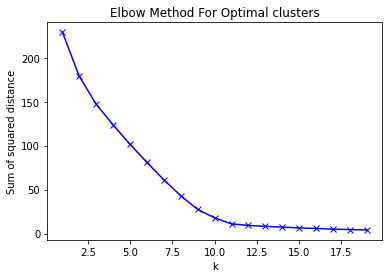

In [74]:

Sum_of_squared_distance = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(lda_output)
    Sum_of_squared_distance.append(km.inertia_)
plt.plot(K, Sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal clusters')
plt.show()

**The elbow drops to an almost flat at 10. Hence, we can see that both hierarchical and kmeans gave similar results.**

In [75]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, random_state=100).fit(lda_output)

In [76]:
clusters = km.labels_.tolist()

In [77]:
df_document_topic['cluster_number']=clusters

**Final Output**

In [78]:
df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,cluster_number
Doc0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0,4
Doc1,0.16,0.01,0.01,0.25,0.01,0.52,0.01,0.01,0.01,0.01,5,7
Doc2,0.01,0.01,0.01,0.34,0.01,0.55,0.01,0.01,0.01,0.01,5,7
Doc3,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0,4
Doc4,0.16,0.01,0.01,0.25,0.01,0.52,0.01,0.01,0.01,0.01,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc495,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5,7
Doc496,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5,7
Doc497,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,7,3
Doc498,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,7,3
